In [1]:
from pymongo import MongoClient
import pandas as pd
from create_ratings_matrix import (create_utility_matrix, dataframe_from_collection)
from bs4 import BeautifulSoup
import json
import numpy as np
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline
from ggplot import *

In [2]:
import pyspark
from pyspark.sql.types import *
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.ml.evaluation import RegressionEvaluator

In [3]:
# Build our Spark Session and Context
spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext
spark, sc

(<pyspark.sql.session.SparkSession at 0x7fa46de15d90>,
 <pyspark.context.SparkContext at 0x7fa49ac7d8d0>)

In [6]:
client = MongoClient('mongodb://localhost:27017/')
db = client.utility_matrix
raw_data = db.utility_matrix.find()
ratings_df_pd = pd.DataFrame(list(raw_data))
ratings_df_pd = ratings_df_pd.drop('_id', axis = 1)

In [7]:
ratings_df_pd.head()

,rating,route_id,user_id
0,1,0,36
1,1,1,36
2,1,2,394
3,1,2,1972
4,1,2,1625


In [8]:
# client = MongoClient('mongodb://localhost:27017/')
# db = client.ratings
# ratings_df_pd = pd.DataFrame(list(db.ratings.find())).drop("_id", axis=1)

In [9]:
ratings_df_pd.shape

(29892, 3)

In [10]:
# Convert to a Spark DataFrame
ratings_df = spark.createDataFrame(ratings_df_pd)

In [11]:
# Check to see we built the DataFrame
ratings_df

DataFrame[rating: bigint, route_id: bigint, user_id: bigint]

In [12]:
# Take a look at the entries in the DataFrame
ratings_df.show(5)

+------+--------+-------+
|rating|route_id|user_id|
+------+--------+-------+
|     1|       0|     36|
|     1|       1|     36|
|     1|       2|    394|
|     1|       2|   1972|
|     1|       2|   1625|
+------+--------+-------+
only showing top 5 rows



In [13]:
train, test = ratings_df.randomSplit([0.8, 0.2], seed=427471138)

In [14]:
# Check to see our split worked
train.count(), test.count()

(23856, 6036)

In [15]:
als_model = ALS(userCol='route_id',
                itemCol='user_id',
                ratingCol='rating',
                nonnegative=True,
                regParam=0.1,
                rank=10
               )

In [16]:
recommender = als_model.fit(train)

### save spark model

In [18]:
path = '/home/david/work/project/Rock-Climbing-Route-Recommender/src/alsmodel'

In [19]:
recommender.save(path)

In [20]:
recommender = ALSModel.load(path)

In [14]:
# test on new user
# Build a single row DataFrame
data = [(1, 500)]
columns = ('route_id', 'user_id')
one_row_spark_df = spark.createDataFrame(data, columns)
# Get the recommender's prediction
recommender.transform(one_row_spark_df).show()

+--------+-------+----------+
|route_id|user_id|prediction|
+--------+-------+----------+
|       1|    500| 0.7332639|
+--------+-------+----------+



In [15]:
# Build a single row DataFrame
data = pd.DataFrame(columns=['route_id', 'user_id'])
data['user_id'] = np.ones(ratings_df_pd['route_id'].shape,dtype=int).tolist()
data['route_id'] = ratings_df_pd['route_id'].tolist()
one_row_spark_df = spark.createDataFrame(data)
pred = recommender.transform(one_row_spark_df).toPandas()

In [16]:
pred.sort_values('prediction', ascending=False).head()

,route_id,user_id,prediction
5050,1978,1,4.438352
24650,702,1,4.438352
26707,2538,1,4.438352
10939,3369,1,4.438352
18245,3202,1,4.438352


In [17]:
# Check that it worked
one_row_spark_df.show()

+--------+-------+
|route_id|user_id|
+--------+-------+
|       0|      1|
|       1|      1|
|       2|      1|
|       2|      1|
|       2|      1|
|       2|      1|
|       3|      1|
|       3|      1|
|       3|      1|
|       3|      1|
|       3|      1|
|       3|      1|
|       3|      1|
|       3|      1|
|       3|      1|
|       3|      1|
|       3|      1|
|       3|      1|
|       3|      1|
|       3|      1|
+--------+-------+
only showing top 20 rows



In [18]:
# Get the factors for user 1 and route 100
user_factor_df = recommender.userFactors.filter('id = 1')
item_factor_df = recommender.itemFactors.filter('id = 100')

In [19]:
user_factors = user_factor_df.collect()[0]['features']
item_factors = item_factor_df.collect()[0]['features']

In [20]:
# Manually (sorta) calculate the predicted rating
np.dot(user_factors, item_factors)

0.63321010523572374

In [21]:
# Get the recommender's prediction
recommender.transform(one_row_spark_df).show()

+--------+-------+----------+
|route_id|user_id|prediction|
+--------+-------+----------+
|     148|      1| 0.7865597|
|     463|      1| 0.5858344|
|     463|      1| 0.5858344|
|     463|      1| 0.5858344|
|     463|      1| 0.5858344|
|     463|      1| 0.5858344|
|     463|      1| 0.5858344|
|     471|      1| 1.3029544|
|     471|      1| 1.3029544|
|     471|      1| 1.3029544|
|     471|      1| 1.3029544|
|     471|      1| 1.3029544|
|     471|      1| 1.3029544|
|     471|      1| 1.3029544|
|     471|      1| 1.3029544|
|     471|      1| 1.3029544|
|     471|      1| 1.3029544|
|     471|      1| 1.3029544|
|     471|      1| 1.3029544|
|     471|      1| 1.3029544|
+--------+-------+----------+
only showing top 20 rows



In [22]:
# Let's take a look all the user factors
recommender.userFactors.show()

+---+--------------------+
| id|            features|
+---+--------------------+
|  0|[0.06774085, 0.08...|
| 10|[0.36928573, 0.00...|
| 20|[0.5476689, 0.745...|
| 30|[0.75599134, 0.84...|
| 50|[0.45170158, 0.10...|
| 60|[0.28742635, 0.32...|
| 70|[0.75862956, 0.37...|
| 80|[0.3829174, 1.002...|
| 90|[0.5150635, 0.472...|
|110|[0.32709587, 0.37...|
|120|[0.46764067, 0.32...|
|140|[0.29996014, 0.29...|
|150|[0.0, 0.04115509,...|
|160|[0.11061484, 0.0,...|
|170|[0.29387653, 0.37...|
|180|[0.88746965, 0.31...|
|190|[0.5150635, 0.472...|
|200|[0.0, 0.26063898,...|
|210|[0.5150635, 0.472...|
|220|[0.5150635, 0.472...|
+---+--------------------+
only showing top 20 rows



In [21]:
# Make predictions for the whole test set
predictions = recommender.transform(test)

In [16]:
type(recommender)

pyspark.ml.recommendation.ALSModel

In [22]:
# Dump the predictions to Pandas DataFrames to make our final calculations easier
predictions_df = predictions.toPandas()
train_df = train.toPandas()

In [23]:
# Fill any missing values with the mean rating
# There are multiple things you could fill with, this is just one example
predictions_df = predictions.toPandas().fillna(train_df['rating'].mean())

In [24]:
predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['prediction'])**2

In [25]:
predictions_df.describe()

,rating,route_id,user_id,prediction,squared_error
count,6036.000000,6036.000000,6036.000000,6036.000000,6.036000e+03
mean,2.714546,1671.271703,986.509940,2.541349,5.190103e-01
std,0.906861,992.891254,575.235577,0.719278,8.308775e-01
min,0.000000,2.000000,0.000000,0.000000,6.508003e-10
25%,2.000000,842.000000,501.000000,2.048946,5.039951e-02
50%,3.000000,1569.000000,949.000000,2.611411,2.110865e-01
75%,3.000000,2430.000000,1457.000000,3.019686,6.232248e-01
max,4.000000,3725.000000,2068.000000,4.738192,1.600000e+01


In [26]:
# Calculate RMSE
np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))

0.72042371350744439

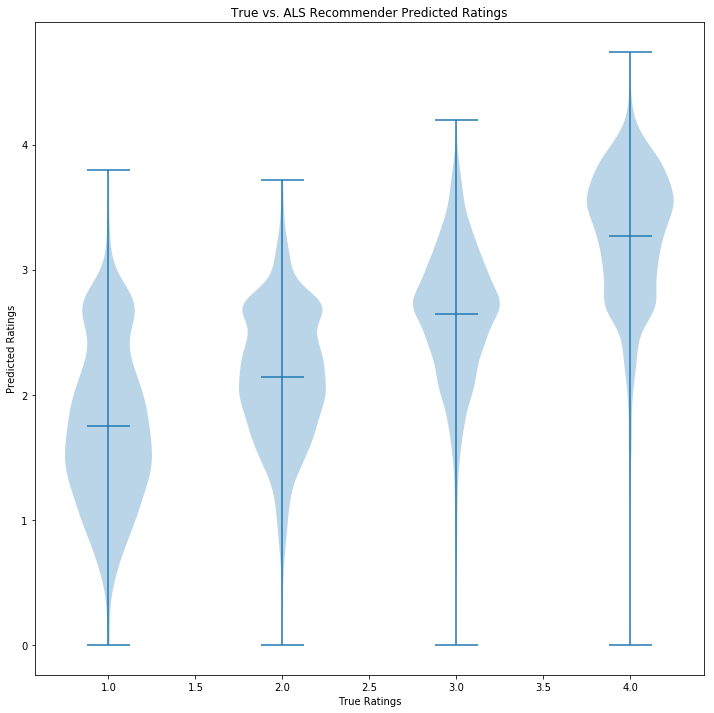

In [30]:
# Create array of predictions for violinplot
data = [predictions_df['prediction'][predictions_df['rating'] == rating] for rating in range(1, 5)]

fig, ax = plt.subplots(1, figsize=(12,12))
ax.violinplot(data, range(1,5), showmeans=True)
ax.set_xlabel('True Ratings')
ax.set_ylabel('Predicted Ratings')
ax.set_title('True vs. ALS Recommender Predicted Ratings')
plt.show()

In [143]:
fig.savefig('violin.jpg')

In [33]:
# see comparision to just average rating
test_df = test.toPandas()
test_df['prediction'] = train_df['rating'].mean()
test_df['squared_error'] = (test_df['rating'] - test_df['prediction'])**2
test_df.head()

,rating,route_id,user_id,prediction,squared_error
0,1,0,0,1.0,0.0
1,1,1,0,1.0,0.0


In [34]:
# Calculate RMSE
np.sqrt(sum(test_df['squared_error']) / len(test_df))

0.0

In [41]:
# see comparision to average rating per route
test_df = test.toPandas()
for route_id in test_df['route_id']:
    test_df['prediction'] = train_df[train_df['route_id']==route_id]['rating'].mean()
test_df['squared_error'] = (test_df['rating'] - test_df['prediction'])**2
# Calculate RMSE
np.sqrt(sum(test_df['squared_error']) / len(test_df))

nan

In [41]:
def get_route_list():
    client = MongoClient('mongodb://localhost:27017/')
    db = client.ratings_collection
    ratings_collection = db.ratings_collection
    collection = ratings_collection.find({"route": {'$exists' : True }})
    route_list = [d['route'].encode('utf-8').lower() for d in list(collection)]
    return route_list

def find_routes_in_list(routes, ratings):
    route_list = get_route_list()
    # drop caps
    routes = routes
    routes_numeric = []
    for route in routes:
        if route.lower() not in route_list:
            # remove from ratings and routes
            ratings.pop(routes.index(route))
            routes.remove(route)
        else:
            routes_numeric.append(route_list.index(route.lower()))
    return routes_numeric, ratings

def build_dataframe(routes, ratings):
    routes, ratings = find_routes_in_list(routes, ratings)
    # make up username
    data = [(66666, route, rating) for route, rating in zip(routes, ratings)]
    columns = ('username', 'route', 'rating')
    return spark.createDataFrame(data, columns)

routes = ['godzilla', 'Aires', 'Breakfast of Champions', 'cultureshock','bendsdsd']
ratings = [4,3,4,4,3]
predict_df = build_dataframe(routes, ratings)
recommender.transform(predict_df).show()

+--------+-----+------+----------+
|username|route|rating|prediction|
+--------+-----+------+----------+
|   66666|  955|     4|       NaN|
|   66666|  684|     3|       NaN|
|   66666| 1704|     4|       NaN|
|   66666| 3473|     4|       NaN|
+--------+-----+------+----------+

